In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost import CatBoostClassifier



In [9]:
#Importation des données clean
X_train=pd.read_csv("data/X_train_after_selection.csv")
y_train=pd.read_csv("data/y_train.csv")
X_val=pd.read_csv("data/X_val_after_selection.csv")
y_val=pd.read_csv("data/y_val.csv")
X_test=pd.read_csv("data/X_test.csv")

data_test = pd.read_csv("data/test.csv")

In [7]:
param_grid = {
    'depth': [4, 6, 8],            
    'learning_rate': [0.01, 0.1, 0.2], 
    'iterations': [100, 200, 500]     
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = CatBoostClassifier(  verbose=0)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=skf,
    verbose=2                 
)

grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
mean_auc_scores = results['mean_test_score']
param_combinations = results['params']

for params, mean_auc in zip(param_combinations, mean_auc_scores):
    print(f"Params: {params}, Mean AUC: {mean_auc:.4f}")

best_params1 = grid_search.best_params_
print("Best params:", best_params1)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.3s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.1s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.2s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   0.1s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.2s
[CV] END .........depth=4, iterations=100, learning_rate=0.2; total time=   0.2s
[CV] END .........depth=4, iterations=100, lear

In [14]:
categorical_features = ['IsActiveMember', 'Geography_Germany', 'Gender_Male']

for col in categorical_features:
    X_train[col] = X_train[col].astype('str')
    X_val[col] = X_val[col].astype('str')
    X_test[col] = X_test[col].astype('str')

Fold 1: Train AUC = 0.9445, Validation AUC = 0.9362
Fold 2: Train AUC = 0.9438, Validation AUC = 0.9395
Fold 3: Train AUC = 0.9424, Validation AUC = 0.9416
Fold 4: Train AUC = 0.9434, Validation AUC = 0.9364
Fold 5: Train AUC = 0.9426, Validation AUC = 0.9402

Mean Train AUC: 0.9433
Mean Validation AUC: 0.9388
Validation AUC Standard Deviation: 0.0022


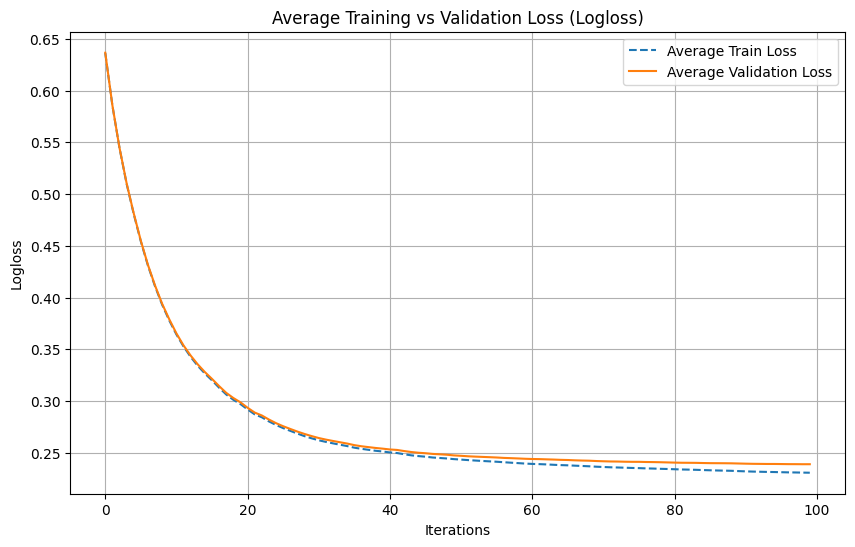

In [16]:
n_splits = 5  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

train_auc_scores = []
val_auc_scores = []
train_losses = []
val_losses = []

params = {
    'depth': 4, 'iterations': 100, 'learning_rate': 0.1,
    'verbose': 0,
    'cat_features': categorical_features,
    'random_state':42
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = CatBoostClassifier(**params)
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

    eval_results = model.get_evals_result()
    train_losses.append(eval_results['learn']['Logloss'])
    val_losses.append(eval_results['validation']['Logloss'])

    y_train_pred = model.predict_proba(X_train_fold)[:, 1]
    y_val_pred = model.predict_proba(X_val_fold)[:, 1]

    train_auc = roc_auc_score(y_train_fold, y_train_pred)
    val_auc = roc_auc_score(y_val_fold, y_val_pred)

    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)

    print(f"Fold {fold + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

mean_train_auc = np.mean(train_auc_scores)
mean_val_auc = np.mean(val_auc_scores)
std_val_auc = np.std(val_auc_scores)

print(f"\nMean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Validation AUC: {mean_val_auc:.4f}")
print(f"Validation AUC Standard Deviation: {std_val_auc:.4f}")

# Calculate average losses across folds
max_iterations = min(len(train_losses[fold]) for fold in range(n_splits))  # Ensure consistent length
avg_train_loss = np.mean([train_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)
avg_val_loss = np.mean([val_losses[fold][:max_iterations] for fold in range(n_splits)], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), avg_train_loss, label='Average Train Loss', linestyle='--')
plt.plot(range(max_iterations), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training vs Validation Loss (Logloss)')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()

#9322 meilleur


Validation ROC AUC on Hold-out Set: 0.9322


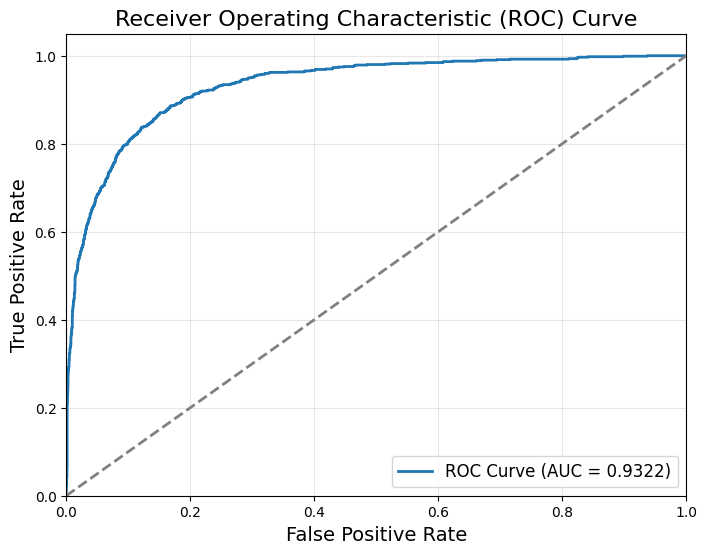

In [20]:
final_model = CatBoostClassifier(
   **params
)
final_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)

# Evaluate on validation set
y_val_pred = final_model.predict_proba(X_val)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [21]:
y_pred_proba_best = final_model.predict_proba(X_test)[:, 1]

sample_submission_test_N = data_test[['id']].copy()  # Copie uniquement la colonne 'id' de data_test
sample_submission_test_N["Exited"] = y_pred_proba_best  # Ajout des probabilités de churn

sample_submission_test_N.to_csv("results.csv", index=False)
